# 1. Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, anderson, spearmanr, skew, normaltest, chi2, norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.kernel_approximation import RBFSampler
import math
import time
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import cross_val_score, KFold
import lightgbm as lgb

import sys
sys.path.append('../../')  
from personal_utils import quick_notify
sys.path.remove('../../')

# 2. Data Loading

In [2]:
filepath = "../data/"

train_df = pd.read_parquet(filepath+"train.parquet")
features = train_df.drop('label', axis = 1)
y = train_df['label']
# test_df = pd.read_parquet(filepath+"test.parquet")

# 3. Pre-Processing
- **Clean dataset**: No missing values detected across all features, eliminating the need for imputation strategies
- **All features informative**: No zero-variance features found, meaning every column provides some variation for modeling
- **Ready for analysis**: The high data quality allows us to proceed directly to exploratory analysis and feature engineering

In [3]:
missing_values = features.isnull().sum()
zero_cols = features.columns[(features == 0).all()].tolist()
inf_cols = features.columns[np.isinf(features).all()].tolist()
zero_var_cols = features.columns[features.nunique() <= 1].tolist()

print(f"Total Features with missing values: {(missing_values > 0).sum()}")
print(f"Total Features with zero variance: {len(zero_cols)+len(inf_cols)+len(zero_var_cols)}")

Total Features with missing values: 0
Total Features with zero variance: 0


In [4]:
known_features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
anonymized_features = [col for col in features.columns if col.startswith('X')]
target = 'label'

print(f"\nKnown features: {len(known_features)}")
print(f"Anonymized features: {len(anonymized_features)}")

print(f"\nKnown features statistical summary:")
print(features[known_features].describe())

print(f"\nData types of known features:")
print(features[known_features].dtypes.value_counts())


Known features: 5
Anonymized features: 780

Known features statistical summary:
             bid_qty        ask_qty        buy_qty       sell_qty  \
count  525886.000000  525886.000000  525886.000000  525886.000000   
mean        9.967948      10.174161     131.712690     132.660088   
std        15.645712      15.889598     307.184897     309.728730   
min         0.001000       0.001000       0.000000       0.000000   
25%         2.634000       2.678000      26.407000      27.020250   
50%         6.415000       6.538000      57.015000      58.044500   
75%        13.085000      13.330000     127.626000     129.100500   
max      1114.932000    1352.965000   17609.567000   17685.503000   

              volume  
count  525886.000000  
mean      264.372778  
std       588.457585  
min         0.000000  
25%        60.687000  
50%       120.790500  
75%       256.730750  
max     28685.346000  

Data types of known features:
float64    5
Name: count, dtype: int64


# 5. Descriptive Statistics 

## 5.1 Raw Statistics

- **Mean and standard deviation:** After scaling, the average mean is approximately `-1.94e-18` and the average standard deviation is `1.000`, confirming that features are properly centered and standardized.

- **Mean to median difference:** The average absolute difference between mean and median is `0.0588`, indicating slight asymmetry in the features' central tendency.

- **Skewness:** Examination of skew shows substantial asymmetry, with the average absolute skewness across features being `1.966`, highlighting the presence of strong right- or left-skewed distributions.

- **Normality:** Both naive and combined normality checks provide strong evidence of non-normality, with the average normality p-value ≈ `1.96e-55` and the Stouffer combined p-value = `0.0`, confirming that the scaled features deviate significantly from normal distributions.

- **Relative variability:** The average relative IQR across features is `176.08`, reflecting extreme relative spread in the data. Using IQR normalized by the median provides more stability than the traditional coefficient of variation. This indicates that many features fluctuate substantially relative to their typical values, suggesting high variability and potential noise.

- **Distribution insight:** While individual statistics don't average perfectly, the combined view reveals that features are likely skewed, highly variable, and noisy - characteristics that may require robust modeling approaches or additional preprocessing techniques.

In [5]:
scaled_df = features.copy()
scaler = StandardScaler()

scaled_array = scaler.fit_transform(scaled_df)
scaled_df_x = pd.DataFrame(scaled_array, columns=features.columns, index=features.index)

In [6]:
avg_mean = scaled_df_x.mean().mean()
avg_std = scaled_df_x.std().mean()

avg_median_diff = (scaled_df_x.mean() - scaled_df_x.median()).abs().mean()

avg_abs_skew = scaled_df_x.apply(lambda x: abs(skew(x, nan_policy='omit'))).mean()

avg_normality_p = scaled_df_x.apply(lambda x: normaltest(x, nan_policy='omit').pvalue).mean()

iqr_per_feature = scaled_df.quantile(0.75) - scaled_df.quantile(0.25)
relative_iqr = iqr_per_feature / scaled_df.median().replace(0, np.nan).abs()
average_relative_iqr = relative_iqr.mean()

p_values = scaled_df_x.apply(lambda x: normaltest(x, nan_policy='omit').pvalue)
p_values = np.clip(p_values, 1e-300, 1 - 1e-16)
z_scores = norm.ppf(1 - p_values)
combined_z = np.sum(z_scores) / np.sqrt(len(z_scores))
combined_p_stouffer = 2 * (1 - norm.cdf(combined_z))

print("Average Mean:", avg_mean)
print("Average Std Dev:", avg_std)

print("Average Difference between Mean and Median:", avg_median_diff)
print("Average Absolute Skewness (Magnitude):", avg_abs_skew)
print("Average Normality p-value (Naive):", avg_normality_p)
print("Combined p-value (Stouffer method):", combined_p_stouffer)
print("Average Relative IQR: ", average_relative_iqr)

Average Mean: -1.943804964647886e-18
Average Std Dev: 1.0000009507777254
Average Difference between Mean and Median: 0.05878015966792375
Average Absolute Skewness (Magnitude): 1.9657998787162823
Average Normality p-value (Naive): 1.956606999714331e-55
Combined p-value (Stouffer method): 0.0
Average Relative IQR:  176.0826034356882


## 5.3 Randomization Testing

- **Real-label performance:** Cross-validation score of `0.1409 ± 0.0034` using LightGBM.
- **Null-label performance:** Mean score from `20` permutations = `-0.0001 ± 0.0000`.
- **Separation:** Complete separation between real and null distributions with no overlap, indicating clear predictive signal above random chance.
- **Signal-to-noise ratio:** `0.1409`, demonstrating meaningful predictive capacity.
- **Validation:** Strong evidence that the model captures genuine patterns rather than overfitting to noise, confirming the validity of our feature set.
- **Note:** This analysis is lightweight due to computational constraints, but provides essential validation that our predictors contain meaningful signal for the target variable.

In [ ]:
n_null_tests = 20
start_time = time.time()

print(f"Dataset: {scaled_df_x.shape[0]:,} samples, {scaled_df_x.shape[1]} features")
print(f"Null distribution tests: {n_null_tests}")

model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=8,
    n_jobs=-1,
    random_state=42,
    force_col_wise=True
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation on real labels...")
scores_real = cross_val_score(model, scaled_df_x, y, cv=cv, scoring='r2')
mean_score_real = np.mean(scores_real)
std_score_real = np.std(scores_real)

print(f"Real labels CV score: {mean_score_real:.4f} ± {std_score_real:.4f}")
print(f"Individual fold scores: {[f'{score:.4f}' for score in scores_real]}")

print(f"\nBuilding null distribution ({n_null_tests} tests)...")
shuffled_scores = []

for i in range(n_null_tests):
    print(f"  Null test {i+1}/{n_null_tests}...", end=" ")
    
    np.random.seed(42 + i)
    y_shuffled = np.random.permutation(y)
    
    scores_shuffled = cross_val_score(model, scaled_df_x, y_shuffled, cv=cv, scoring='r2')
    mean_shuffled = np.mean(scores_shuffled)
    shuffled_scores.append(mean_shuffled)
    
    print(f"Score: {mean_shuffled:.4f}")

shuffled_scores = np.array(shuffled_scores)
mean_null = np.mean(shuffled_scores)
std_null = np.std(shuffled_scores)
max_null = np.max(shuffled_scores)
min_null = np.min(shuffled_scores)

signal_to_noise = mean_score_real - mean_null
signal_to_noise_std = signal_to_noise / std_null if std_null > 0 else np.inf

vs_best_random = mean_score_real - max_null
training_time = time.time() - start_time

print(f"Real Model Performance:")
print(f"  Mean CV Score: {mean_score_real:.4f} ± {std_score_real:.4f}")
print(f"  Score Range: {np.min(scores_real):.4f} to {np.max(scores_real):.4f}")

print(f"\nNull Distribution (n={n_null_tests}):")
print(f"  Mean Score: {mean_null:.4f} ± {std_null:.4f}")
print(f"  Score Range: {min_null:.4f} to {max_null:.4f}")

print(f"\nSignal Analysis:")
print(f"  Signal-to-Noise Ratio: {signal_to_noise:.4f}")
print(f"  Signal-to-Noise (std): {signal_to_noise_std:.2f}")
print(f"  vs Best Random Model: {vs_best_random:.4f}")

print(f"\nExecution:")
print(f"  Total Runtime: {training_time:.1f} seconds")
print(f"  Avg Time per Test: {training_time/(n_null_tests+1):.1f} seconds")

Starting enhanced model validation...
Dataset: 525,886 samples, 785 features
Null distribution tests: 20
Phase 1: Cross-validation on real labels...
[LightGBM] [Info] Total Bins 200155
[LightGBM] [Info] Number of data points in the train set: 420708, number of used features: 785
[LightGBM] [Info] Start training from score 0.037921
[LightGBM] [Info] Total Bins 200155
[LightGBM] [Info] Number of data points in the train set: 420709, number of used features: 785
[LightGBM] [Info] Start training from score 0.035586
[LightGBM] [Info] Total Bins 200155
[LightGBM] [Info] Number of data points in the train set: 420709, number of used features: 785
[LightGBM] [Info] Start training from score 0.035908
[LightGBM] [Info] Total Bins 200155
[LightGBM] [Info] Number of data points in the train set: 420709, number of used features: 785
[LightGBM] [Info] Start training from score 0.035734
[LightGBM] [Info] Total Bins 200155
[LightGBM] [Info] Number of data points in the train set: 420709, number of use

True

# 6. Correlation Analysis

## 6.1 Collinearity

- **Correlation structure:** Analysis reveals distinct blocks of features exhibiting high collinearity, suggesting underlying factor structures or related information sources within the dataset.
- **Feature groupings:** These collinear clusters, combined with relatively low individual correlations to the target variable, suggest that dimensionality reduction or feature decomposition techniques could extract more meaningful predictive signals.

In [ ]:
sample_num = 100000
print(f"Calculating Feature Correlation Matrix with {sample_num} rows")

rows = np.random.choice(features.index, size=min(sample_num, len(features)), replace=False)
corr_mat = features.loc[rows].corr(method='spearman')

Calculating Feature Correlation Matrix with 100000 rows


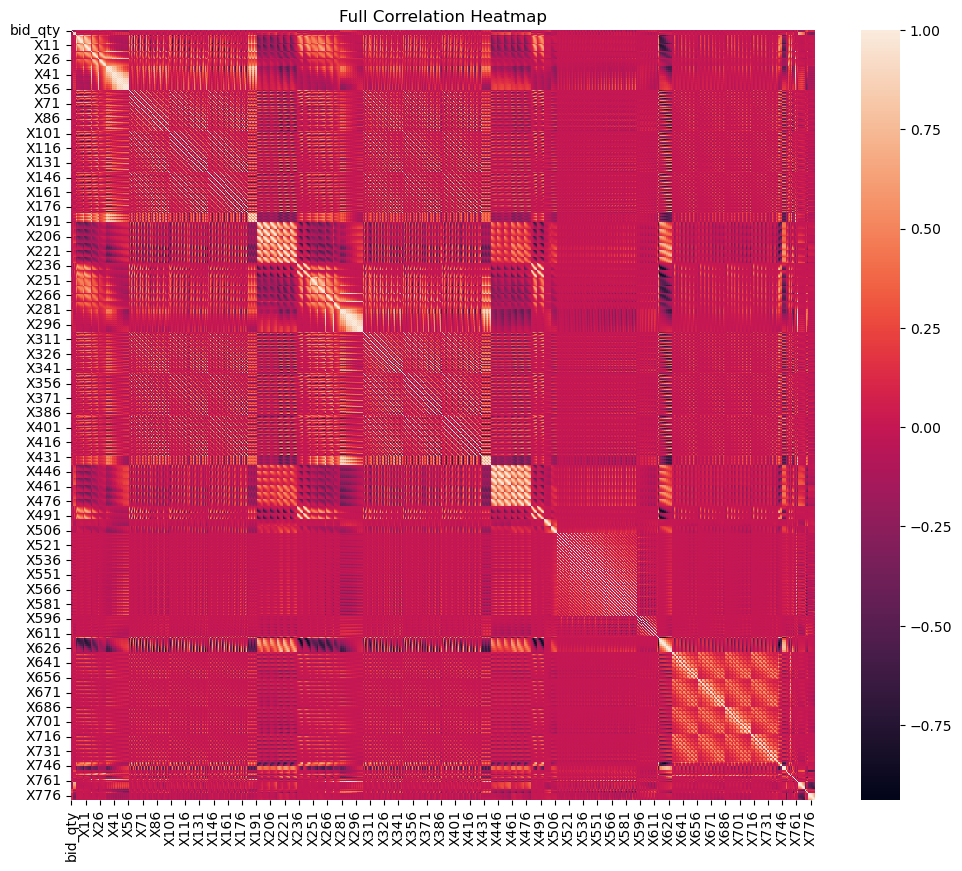

In [19]:
plt.figure(figsize=(12, 10))

plt.title("Full Correlation Heatmap")

sns.heatmap(corr_mat)

plt.show()

## 6.3 Target Correlation

- **Weak linear relationships:** The highest correlated features show correlations of approximately `0.01` with the target variable, with very few features reaching even this modest level.
- **Distribution of correlations:** The histogram reveals that the majority of features cluster around zero correlation, indicating minimal linear predictive power at the individual feature level.
- **Modeling strategy:** Given these weak linear relationships, extracting predictive value will likely require capturing nonlinear interactions between features rather than relying on individual feature correlations.

In [ ]:
print("Calculating Correlation with target variable")

target_corrs = features.apply(lambda x: x.corr(y, method='spearman')).sort_values(ascending=False)

plt.figure()

plt.hist(abs(target_corrs), bins='auto')
plt.title("Histogram of feature correlations with target (Absolute Value)")
plt.xlabel("Correlations")
plt.ylabel("Freq")

plt.show()

Calculating Correlation with target variable


### 6.3.1 Feature Histograms

- **Top correlated features:** Analysis focuses on the 20 features with highest absolute correlation to the target variable for detailed visual inspection.
- **Distribution patterns:** Visual examination reveals predominantly non-normal distributions across these features, consistent with our earlier statistical testing and reinforcing the need for robust modeling approaches.

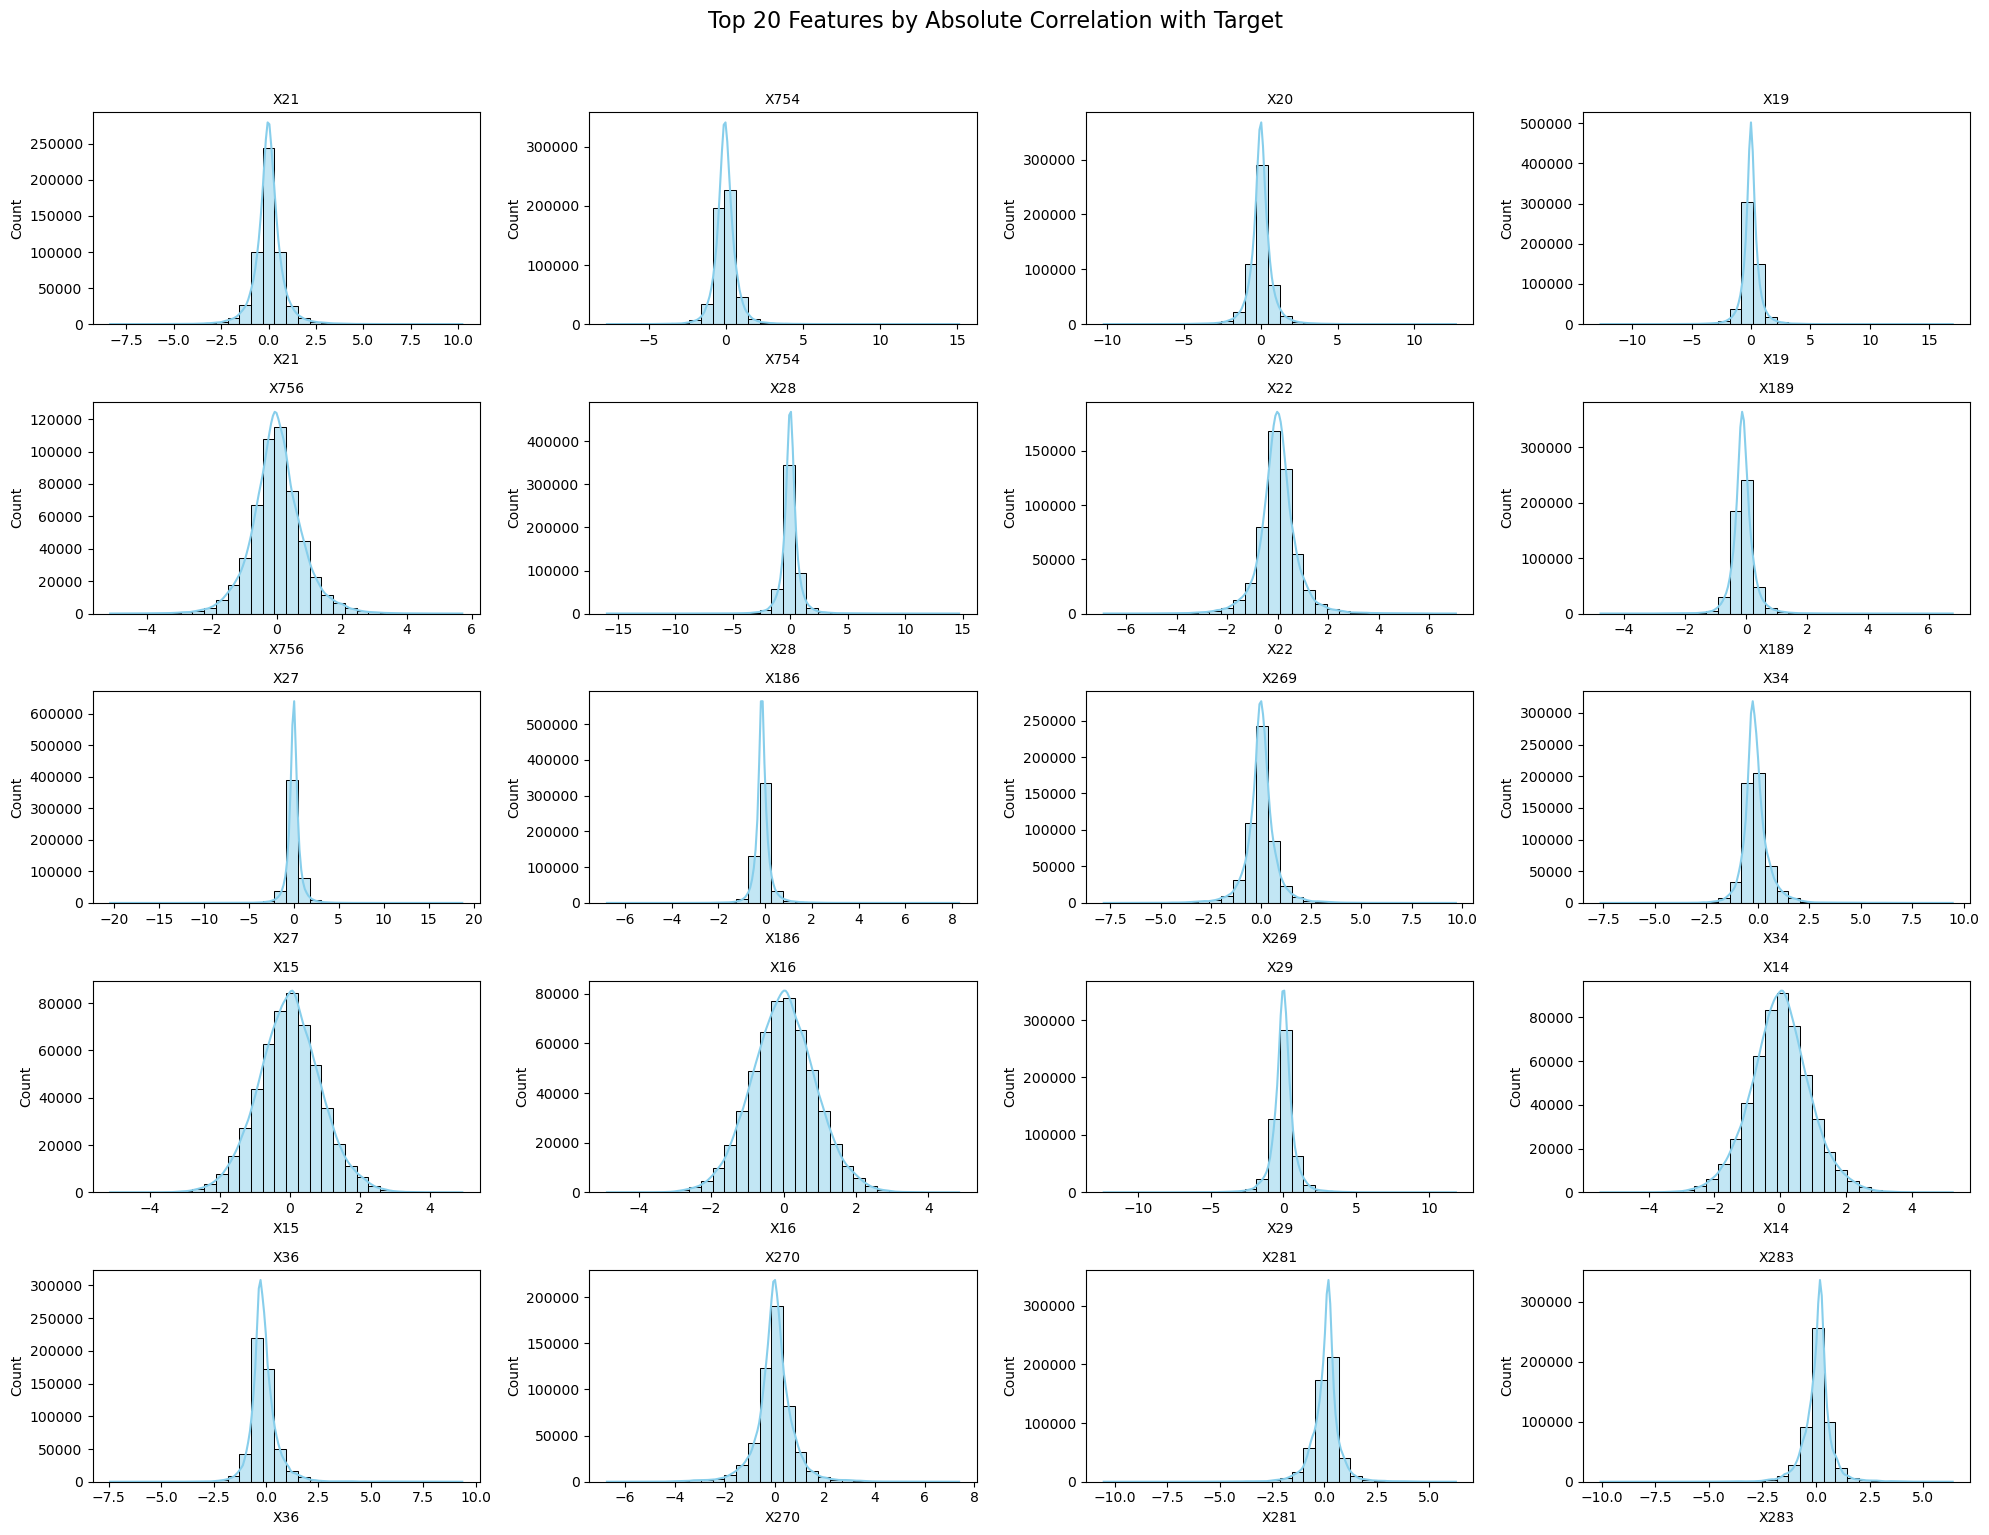

In [ ]:
top_20_corr = abs(target_corrs).reset_index().head(20)['index'].tolist()

fig, axes = plt.subplots(5, 4, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(top_20_corr):
    if feature in features.columns:
        sns.histplot(features[feature].dropna(), bins=30, kde=True, ax=axes[i],
                     color="skyblue", edgecolor="black")
        axes[i].set_title(feature, fontsize=10)
    else:
        axes[i].set_visible(False)

fig.suptitle("Top 20 Features by Absolute Correlation with Target", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

# 7. Dimensionality Reduction

- **Method comparison:** While techniques like t-SNE were explored, they provided limited actionable insights for this dataset structure.
- **Linear approach:** PCA analysis indicates optimal dimensionality around 143 components, suggesting substantial redundancy in the original feature space.
- **Nonlinear approach:** Given the weak linear correlations observed earlier, autoencoder-based dimensionality reduction is employed to capture potential nonlinear dependencies between features.
- **Integration strategy:** The resulting dimensionality reduction features will be incorporated alongside original features in the final modeling pipeline.

## 7.1 Linear PCA

- **Dimensionality requirements:** 143 components are needed to achieve 95% cumulative variance, indicating substantial dimensionality in the underlying data structure.
- **Scree plot analysis:** No clear elbow point is evident, suggesting gradual rather than sharp variance drop-offs across components.
- **Practical considerations:** While the high dimensionality isn't prohibitive for prediction tasks, more compact representations facilitate faster experimentation and model iteration during development.

Components needed for 95% Cumulative Variance: 143


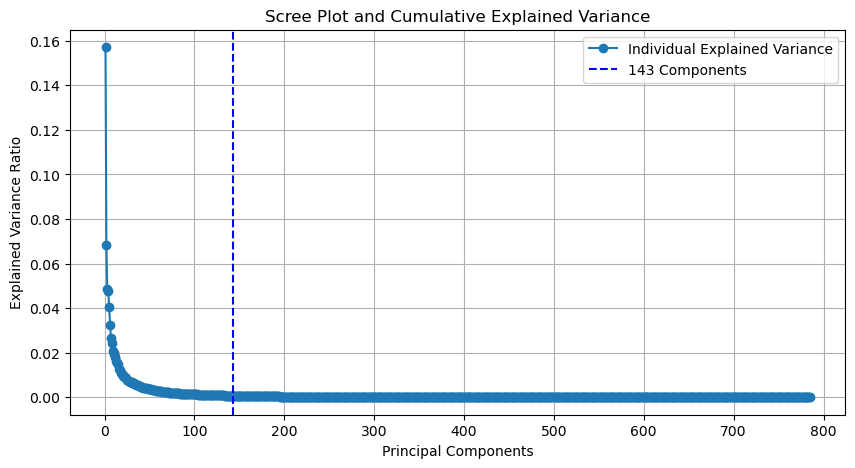

In [ ]:
X = scaled_df_x.copy()

pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_pca = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

n_95 = np.argmax(cum_explained_var >= 0.95) + 1
print("Comps for 95% Cumulative Variance:", n_95)

plt.figure(figsize=(10,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label="Individual Explained Variance")
#plt.plot(range(1, len(cum_explained_var)+1), cum_explained_var, marker='s', label="Cumulative Explained Variance")
#plt.axhline(y=0.95, color='r', linestyle='--', label="95% Threshold")
plt.axvline(x=np.argmax(cum_explained_var >= 0.95)+1, color='b', linestyle='--', 
            label=f"{np.argmax(cum_explained_var >= 0.95)+1} Components")

plt.title("Scree Plot and Cumulative Explained Variance")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.grid(True)
plt.show()

# 8. Summary + Next Steps

## Key Findings
- **Data quality:** Clean dataset with no missing values, but features exhibit substantial non-normality (average absolute skewness = `1.966`) and extreme variability (average relative IQR = `176.08`).
- **Predictive challenges:** Weak linear relationships with target variable (highest correlation ≈ `0.01`) suggest limited individual feature predictive power.
- **Feature structure:** Clear blocks of collinear variables identified, with PCA requiring 143 components for 95% variance retention, indicating high-dimensional underlying structure.
- **Model validation:** Randomization testing confirms genuine predictive signal (CV score: `0.1409 ± 0.0034` vs null: `-0.0001 ± 0.0000`).

## Recommended Next Steps
- **Robust preprocessing:** Consider more robust standardization techniques (e.g., RobustScaler, quantile transforms) to handle extreme variability and skewness rather than standard scaling.
- **Nonlinear feature extraction:** Implement autoencoder-based dimensionality reduction to capture nonlinear interactions that linear methods may miss.
- **Feature selection:** Apply Random Forest feature importance and SHAP analysis to identify the most predictive features and interactions.
- **Collinearity management:** Use dimensionality reduction techniques to compress collinear feature blocks into meaningful composite features.
- **Model strategy:** Focus on ensemble methods and nonlinear models given the weak linear relationships and complex feature interactions.